In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from requests import get
from json import dumps

plt.rc('font', size=14) #controls default text size
plt.rc('axes', titlesize=14) #fontsize of the title
plt.rc('axes', labelsize=14) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend

In [2]:
# date daily vaccination data avaliable from
first_data = datetime(2021, 1, 10)

# date to forecast until
end_date = datetime(2021, 10, 5)

# calculate average across this many days and forecast no.
# doses given today to be the same as this many days ago
n_avg = 7

# days after 1st dose that 2nd dose given
second_dose_days = 77

# no. people getting vaccinations
priority_totals = {
    "Groups 1-4": 15e6,
    "Groups 1-9": 32e6,
    "All Adults": 53e6
}
uk_pop = priority_totals["All Adults"]

In [3]:
ENDPOINT = "https://api.coronavirus.data.gov.uk/v1/data"
AREA_TYPE = "overview"

filters = [
    f"areaType={ AREA_TYPE }",
]
structure = {
    "date": "date",
    "newFirst": "newPeopleVaccinatedFirstDoseByPublishDate",
    "cumFirst": "cumPeopleVaccinatedFirstDoseByPublishDate",
    "newSecond": "newPeopleVaccinatedSecondDoseByPublishDate",
    "cumSecond": "cumPeopleVaccinatedSecondDoseByPublishDate",
}
api_params = {
    "filters": str.join(";", filters),
    "structure": dumps(structure, separators=(",", ":"))
}
response = get(ENDPOINT, params=api_params, timeout=10)

if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')

j = response.json()
if j["length"] >= j["maxPageLimit"]:
    raise NotImplementedError("Request spans multiple pages")

df = pd.DataFrame(j["data"])
df.set_index("date", inplace=True)
df.index = pd.to_datetime(df.index)

df["newTot"] = df["newFirst"] + df["newSecond"]
df["cumTot"] = df["cumFirst"] + df["cumSecond"]

df.head()

,newFirst,cumFirst,newSecond,cumSecond,newTot,cumTot
date,,,,,,
2021-03-22,329897.0,28327873,82300.0,2363684,412197.0,30691557
2021-03-21,367006.0,27997976,52612.0,2281384,419618.0,30279360
2021-03-20,752308.0,27630970,91977.0,2228772,844285.0,29859742
2021-03-19,614930.0,26878662,125725.0,2136795,740655.0,29015457
2021-03-18,528260.0,26263732,132016.0,2011070,660276.0,28274802


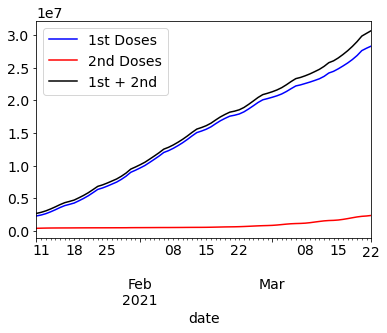

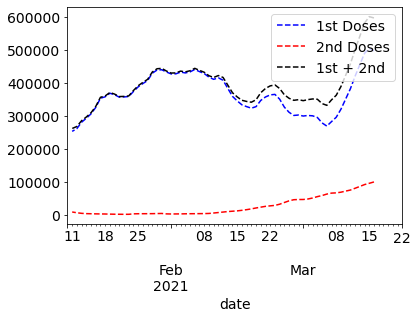

In [4]:
df["cumFirst"].plot(color="b", label="1st Doses")
df["cumSecond"].plot(color="r", label="2nd Doses")
df["cumTot"].plot(color="k", label="1st + 2nd")
plt.legend()

plt.figure()
df.rolling(window=n_avg).mean()["newFirst"].plot(color="b", linestyle="--", label="1st Doses")
df.rolling(window=n_avg).mean()["newSecond"].plot(color="r", linestyle="--", label="2nd Doses")
df.rolling(window=n_avg).mean()["newTot"].plot(color="k", linestyle="--", label="1st + 2nd")
plt.legend()

In [5]:
last_data = df.index.max()
df = df.append(pd.DataFrame(index=pd.date_range(last_data, end_date, closed="right")))
df.sort_index(inplace=True)

In [6]:
future_dates = pd.date_range(start=last_data + timedelta(days=1), end=end_date)
for d in future_dates:
    if d - timedelta(days=second_dose_days) < first_data:
        pending_2nd_doses = 0
    else:
        # no. second doses needed today is difference between total
        # 2nd doses so far and 1st doses second_dose_days ago (who
        # now require 2nd dose)
        dose2_req = df.loc[
            d - timedelta(days=second_dose_days), "cumFirst"
        ]
        dose2_sofar =  df.loc[
            d - timedelta(days=1), "cumSecond"
        ]
        pending_2nd_doses = max([0, dose2_req - dose2_sofar])

    # forecast to give same doses today as n_avg days ago
    total_doses_today = df.loc[d - timedelta(days=n_avg), "newTot"]
    if total_doses_today + df.loc[d - timedelta(days=1), "cumTot"] > 2 * uk_pop:
        total_doses_today = 2 * uk_pop - df.loc[d - timedelta(days=1), "cumTot"]
    df.loc[d, "newTot"] = total_doses_today
    
    dose2_today = min(pending_2nd_doses, total_doses_today)
    df.loc[d, "newSecond"] = dose2_today
    df.loc[d, "cumSecond"] = df.loc[d - timedelta(days=1), "cumSecond"] + df.loc[d, "newSecond"]

    dose1_remaining = uk_pop - df.loc[d - timedelta(days=1), "cumFirst"]
    dose1_today = min(total_doses_today - dose2_today, dose1_remaining)
    df.loc[d, "newFirst"] = dose1_today
    df.loc[d, "cumFirst"] = df.loc[d - timedelta(days=1), "cumFirst"] + df.loc[d, "newFirst"]

    df.loc[d, "cumTot"] = df.loc[d, "cumFirst"] + df.loc[d, "cumSecond"]


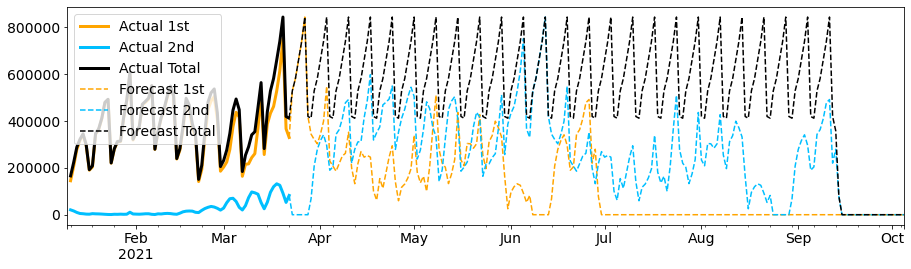

In [11]:
plt.figure(figsize=(15, 4))

rollFirst = df["newFirst"]  #.rolling(window=n_avg).mean()
rollSecond = df["newSecond"]  #.rolling(window=n_avg).mean()
#rollTotal = df["newTot"]  #.rolling(window=n_avg).mean()

rollFirst[rollFirst.index <= last_data].plot(color="orange", label="Actual 1st", linewidth=3)
rollSecond[rollSecond.index <= last_data].plot(color="deepskyblue", label="Actual 2nd", linewidth=3)
rollTotal[rollTotal.index <= last_data].plot(color="k", label="Actual Total", linewidth=3)

rollFirst[rollFirst.index >= last_data].plot(color="orange", linestyle="--", label="Forecast 1st")
rollSecond[rollSecond.index >= last_data].plot(color="deepskyblue", linestyle="--", label="Forecast 2nd")
rollTotal[rollTotal.index >= last_data].plot(color="k", linestyle="--", label="Forecast Total")

plt.legend(loc="upper left")


In [14]:
rollFirst[50:].head(25)

2021-03-01    203168.0
2021-03-02    224996.0
2021-03-03    278956.0
2021-03-04    376244.0
2021-03-05    437463.0
2021-03-06    416834.0
2021-03-07    164143.0
2021-03-08    215273.0
2021-03-09    217301.0
2021-03-10    243887.0
2021-03-11    260809.0
2021-03-12    369578.0
2021-03-13    512108.0
2021-03-14    257010.0
2021-03-15    386685.0
2021-03-16    433320.0
2021-03-17    462246.0
2021-03-18    528260.0
2021-03-19    614930.0
2021-03-20    752308.0
2021-03-21    367006.0
2021-03-22    329897.0
2021-03-23    529119.0
2021-03-24    581855.0
2021-03-25    660276.0
Name: newFirst, dtype: float64

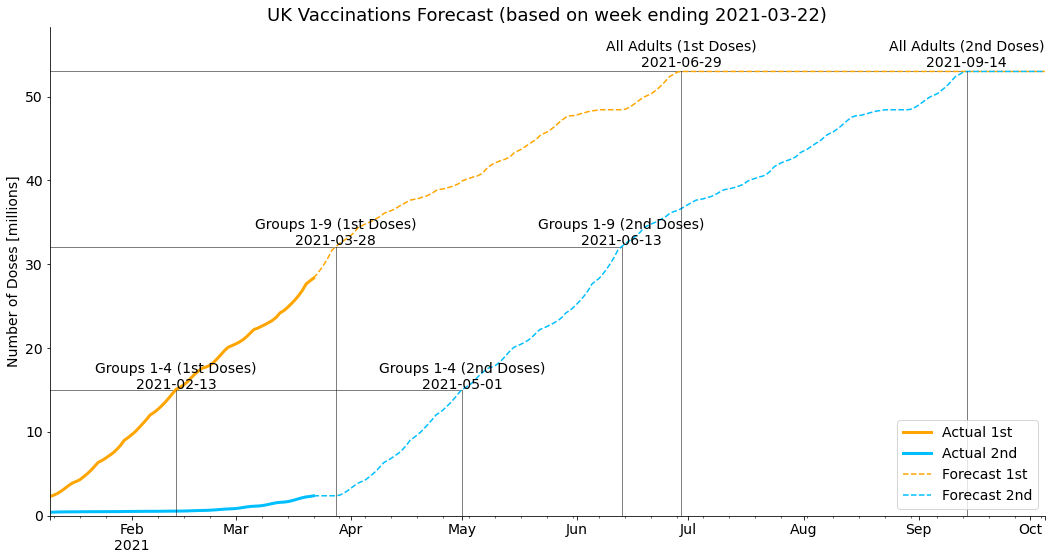

In [10]:
plt.figure(figsize=(15, 8))

cumFirst = df["cumFirst"] / 1e6
cumSecond = df["cumSecond"] / 1e6

cumFirst[cumFirst.index <= last_data].plot(color="orange", label="Actual 1st", linewidth=3)
cumSecond[cumSecond.index <= last_data].plot(color="deepskyblue", label="Actual 2nd", linewidth=3)

cumFirst[cumFirst.index >= last_data].plot(color="orange", linestyle="--", label="Forecast 1st")
cumSecond[cumSecond.index >= last_data].plot(color="deepskyblue", linestyle="--", label="Forecast 2nd")

for name, pop in priority_totals.items():
    plt.ylim([0, uk_pop*1.1/1e6])
    complete_1st_date = df[df["cumFirst"] >= pop].iloc[0].name
    complete_2nd_date = df[df["cumSecond"] >= pop].iloc[0].name
    plt.hlines(pop/1e6, 0, complete_2nd_date , color="k",linewidth=0.5)
    plt.axvline(complete_1st_date, ymax=pop/(uk_pop*1.1), color="k",linewidth=0.5)
    plt.axvline(complete_2nd_date, ymax=pop/(uk_pop*1.1), color="k",linewidth=0.5)
    plt.text(complete_1st_date, pop*1.01/1e6, name + f" (1st Doses)\n{complete_1st_date.date()}", ha="center")
    plt.text(complete_2nd_date, pop*1.01/1e6, name + f" (2nd Doses)\n{complete_2nd_date.date()}", ha="center")

plt.legend(loc="lower right")
plt.ylabel("Number of Doses [millions]")
plt.title(f"UK Vaccinations Forecast (based on week ending {last_data.date()})", fontsize=18)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.tight_layout()
plt.savefig("vax_forecast.png", dpi=150)